# LABS-5: Fairness in Machine Learning

In this lab we will explore an example of unnmitigated machine learning to observe how a model performs for different protected classes. We will be using the Fairlearn package to calculate various metrics to help us understand how our model performs across different classes. 

Check out their user guide for more information on the package! https://fairlearn.org/v0.10/user_guide/fairness_in_machine_learning.html

In [14]:
# You may have to run this cell to install the fairlearn package we'll be using today. You should only have to do this once.

!pip install fairlearn

In [15]:
# import packages

import pandas as pd
import numpy as np
import fairlearn.metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, true_positive_rate, false_positive_rate, selection_rate, demographic_parity_ratio

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) ## ignore deprecation warnings

# Adult Census Data

In this model we will be using demographic variables from census data to predict whether someone makes >50k or <=50k using data from: https://archive.ics.uci.edu/dataset/2/adult. A truncated/precleaned version of this is accessible through the `fairlearn` package, so we will import it from there.

### Load in and explore/clean up the data

In [16]:
## import and view the data

from fairlearn.datasets import fetch_adult
census_raw = fetch_adult(as_frame=True)
census = census_raw.frame #this grabs the data in a pd.dataframe format


census.head() # this prints the first 5 lines so we can see the format of the data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [17]:
## create lists of categorical/numerical columns

census_catcols = list(census.select_dtypes('category')) # categorical columns

census_numcols = list(set(census.columns) - set(census_catcols)) # numerical columns

In [18]:
## get some info on the numerical data - gives us a general idea of spread and center
census.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


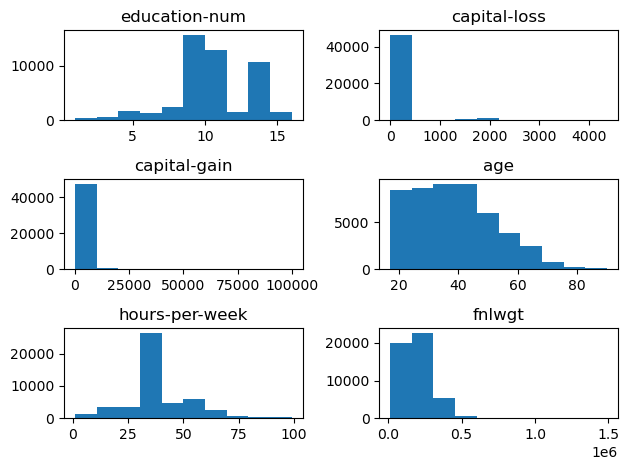

In [19]:
## Visualize the spread of numeric data

fig, axs = plt.subplots(3,2)
axs = axs.ravel()
for idx,ax in enumerate(axs):
    ax.hist(census[census_numcols[idx]])
    ax.set_title(census_numcols[idx])
plt.tight_layout()

In [20]:
## info on the categorical data
# This shows us the levels in the categories for the first 2 category columns

for col in census_catcols[:2]:
    print(census[col].value_counts(), "\n")

# Most of the columns have a ton of categories, we can combine some of them to collapse the categories. 
# Typically we don't want ot have more than 5ish categories in a given column

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64 

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64 



In [21]:
## Collapsing some categories...

# combining similar working classes
census['workclass'].replace(['Without-pay', 'Never-worked',], 'No-inc', inplace=True)
census['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
# print(census['workclass'].value_counts())

# making race binary White/Non-White
census['race'] = (census.race.apply(lambda x: x if x == 'White' else "Non-White")).astype('category')
# print(census['race'].value_counts())

# combining similar education classes
census['education'].replace(['11th', '10th', '9th', '12th',], 'Some-HS', inplace=True)
census['education'].replace(['7th-8th', '5th-6th', '1st-4th', 'Preschool',], 'No-HS', inplace=True)
census['education'].replace(['Assoc-voc', 'Assoc-acdm', 'Prof-school'], 'Continued Ed', inplace=True)
census['education'].replace(['Bachelors', 'Masters', 'Doctorate'], 'College_+', inplace=True)
# print(census['education'].value_counts())

# combining similar marital statuses
census['marital-status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married', inplace=True)
census['marital-status'].replace(['Divorced', 'Separated', 'Widowed'], 'Was-Married', inplace=True)
# print(census['marital-status'].value_counts())

# keeping only the top 4 countries (based on number of observations), grouping all others into "Other" category
top_country = census['native-country'].value_counts()[:5]
census['native-country'] = (census['native-country'].apply(lambda x: x if x in top_country else "Other")).astype('category')
# print(census['native-country'].value_counts())

# keeping only the top 4 occupations (based on number of observations), grouping all others into "Other" category
top_occ = census['occupation'].value_counts()[:5]
census['occupation'] = (census['occupation'].apply(lambda x: x if x in top_occ else "Other")).astype('category')
# print(census['occupation'].value_counts())


##### A little more pre-processing... 

In [22]:
# Scale numbers, One hot encode categories

census[census_numcols] = MinMaxScaler().fit_transform(census[census_numcols]) #scale the numerical values so they are all on the same scale
census_onehot = pd.get_dummies(census, columns = census_catcols) # creates dummy variables to one-hot encode all categorical variables

## One hot encoding creates a column for each category in a feature and assigns it a True/False value. 
## For example, the 'workclass' column will be broken up into a column for each category ('workclass_Gov', 'workclass_No-inc', etc). 
## A government workclass observation would have a True value in the 'workclass_Gov' column and a False value in all the other workclass columns.
## This is a common strategy you'll see in machine learning - also with 1/0 values instead of True/False (respectively).

In [23]:
census_onehot.drop(['class_<=50K', 'race_White', 'sex_Male'], axis=1, inplace=True) # drop binary category duplicates
census_onehot.head() # visualize what the data looks like after being scaled/one hot encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Gov,workclass_No-inc,workclass_Private,workclass_Self-emp-inc,...,relationship_Wife,race_Non-White,sex_Female,native-country_Germany,native-country_Mexico,native-country_Other,native-country_Philippines,native-country_Puerto-Rico,native-country_United-States,class_>50K
0,0.109589,0.145129,0.400000,0.000000,0.0,0.397959,False,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,0.287671,0.052451,0.533333,0.000000,0.0,0.500000,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,0.150685,0.219649,0.733333,0.000000,0.0,0.397959,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,0.369863,0.100153,0.600000,0.076881,0.0,0.397959,False,False,True,False,...,False,True,False,False,False,False,False,False,True,True
4,0.013699,0.061708,0.600000,0.000000,0.0,0.295918,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


Finally, we need to split it into a training set (to build our model) and testing set (to see how it performs on data it was not trained on).

We also need to split our data into our target ("class_>50K" - denoted as y) and features (everything else - denoted as x)

In [24]:
# split the data into train and test for model

#seperate into features and target ("class_>50K")
census_x = census_onehot.loc[:, census_onehot.columns != "class_>50K"]
census_y = census_onehot.loc[:, census_onehot.columns == "class_>50K"]

#train/test split (75/25)
X_train, X_test, y_train, y_test = train_test_split(census_x, census_y, test_size=0.25, random_state=9658)

# Now, let's look at our data and model and evaluate the fairness

You will answer the following questions using the code/output below. 

### Questions

1. The metrics we will be using in this lab are True Positive Rate, False Positive Rate, Selection Rate, Demographic Parity Ratio, and Equalized Odds Ratio. Define each of these metrics, including any relevant math equations, the range (i.e. what number represents complete fairness? Unfairness?), and the situational implication of what this metric represents. 

2. What are the protected classes in this dataset? Are these classes equally represented in the data? 

3. For each protected class, what group is being favored in the model?

4. Based on the fairness metrics you observed, is the model fair – why/why not? 

5. Given the goals of this model, do you think it should be used? Why/why not.

### Looking at the data distribution

Type the name of the protected class you'd like to explore in the quotes below. Be sure to use the exact name (case sensitive!) of the column from the data frame above.

sex
Male      32650
Female    16192
Name: count, dtype: int64


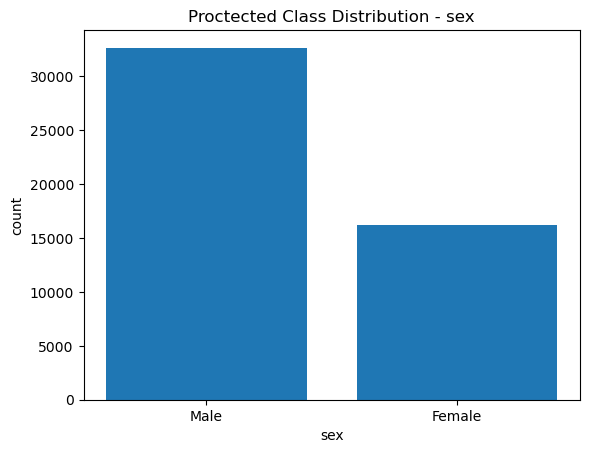

In [25]:
protectedClass = "sex" # type the protected class you'd like to explore in the quotes here

print(census[protectedClass].value_counts()) #print the number of observations in each class

#visualize the difference in class representation
plt.bar(census[protectedClass].value_counts().index.values, census[protectedClass].value_counts().values)
plt.ylabel('count')
plt.xlabel(protectedClass)
plt.title(f"Proctected Class Distribution - {protectedClass}")
plt.show()

## Model buliding

It's finally time to build our model!

We'll be building a simple logistic regression model to predict if a person makes more than 50k a year.

Basically, a logistic regression works by calculating a *probability* of an observation being in a spcified class for the target variable. So in this case, our model will produce a probability of a person making more than 50k. This probability is compared to a threshold value, and if the probability is above the threshold is will be categorized as a positive outcome (in this case, making more thank 50k). For more information on logistic regressions, check out this IBM page: https://www.ibm.com/topics/logistic-regression#:~:text=Logistic%20regression%20estimates%20the%20probability,given%20dataset%20of%20independent%20variables. 

In [26]:
## train model

lreg = LogisticRegression() #initialize a logistic regression model
lreg.fit(X_train, y_train) #train this model using our training data

y_pred = lreg.predict(X_test) # store predicted values for the test set

c:\Users\wat6sv\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wat6sv\AppData\Local\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Average accuracy on test data

In [27]:
print("Average accuracy on test data:\t",round(lreg.score(X_test, y_test)*100,2),"%")


Average accuracy on test data:	 84.53 %


### Fairness Metrics

We are using the Fairlearn package in Python. 

You will need to understand what the metric used below mean and how they are calculated. You can find information on the functions used in their documentation: https://fairlearn.org/v0.10/api_reference/index.html#module-fairlearn.metrics

In [76]:
# Construct a function dictionary with the metrics we'd like for each class
my_metrics = {
    'true positive rate' : true_positive_rate,
    'false positive rate' : false_positive_rate,
    'selection rate' : selection_rate,
    'count' : count
}
# Construct a MetricFrame for race
mf_race = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test["race_Non-White"]
)

# Construct a MetricFrame for sex
mf_sex = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test["sex_Female"]
)

In [54]:
def create_confmatrix(y_test, y_pred):
    '''
    creates a confusion matrix with more descriptive formatting
    '''
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() # grab the individual values
    
    # create a data frame with the values in the correct spots
    conf_matrix = pd.DataFrame({'predicted positive': [tp, fp], 
                                'predicted negative': [fn, tn]},
                                index=['actual positive','actual negative'])
    
    # return the dataframe to be saved/viewed
    return conf_matrix

#### Overall metrics

Here is the confusion matrix for the model overall with *counts* for the true positive, false positive, true negative, and false negative.

For more information on confusion matrices, check out the wiki page: https://en.wikipedia.org/wiki/Confusion_matrix

In [74]:
# overall confusion matrix
print("Confusion matrix for all test data:") 
create_confmatrix(y_test, y_pred)

Confusion matrix for all test data:


,predicted positive,predicted negative
actual positive,1669,1284
actual negative,605,8653


In [82]:
## The overall metrics. You'll use these to compare to with the metrics broken down by each protected class below. 
## Think about how the differing performance would impact that group based on your understanding of each metric.
pd.DataFrame(mf_race.overall, columns = ["overall"]).T

,true positive rate,false positive rate,selection rate,count
overall,0.565188,0.065349,0.186226,12211.0


Now we can look at fairness metrics for each protected class:

#### Race

In [37]:
## metrics broken down by race classes. Compare these to the metrics above. 
mf_race.by_group

,true positive rate,false positive rate,selection rate,count
race_Non-White,,,,
False,0.572874,0.070543,0.199347,10409.0
True,0.492958,0.038867,0.110433,1802.0


In [28]:
# Derived fairness metrics. Be sure you understand the scale and meaning of these.

dpr_race = fairlearn.metrics.demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test.filter(regex="race.*"))
print("Demographic Parity ratio:\t", dpr_race)

eodds_race = fairlearn.metrics.equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test.filter(regex="race.*"))
print("Equalized Odds ratio:\t\t", eodds_race)

Demographic Parity ratio:	 0.5539737640907693
Equalized Odds ratio:		 0.5509707683620727


#### Sex

In [29]:
## metrics broken down by sex classes. Compare these to the metrics above. 

mf_sex.by_group

,true positive rate,false positive rate,selection rate,count
sex_Female,,,,
False,0.591419,0.096322,0.246831,8204.0
True,0.422658,0.015502,0.062141,4007.0


In [30]:
# Derived fairness metrics. Be sure you understand the scale and meaning of these.

dpr_sex = fairlearn.metrics.demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test.filter(regex="sex.*"))
print("Demographic Parity ratio:\t", dpr_sex)

eodds_sex = fairlearn.metrics.equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test.filter(regex="sex.*"))
print("Equalized Odds ratio:\t\t", eodds_sex)

Demographic Parity ratio:	 0.25175646322639084
Equalized Odds ratio:		 0.16093573844419393
